In [3]:
import numpy as np
from skimage import io, color, measure
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
import math
import os 
from skimage.transform.integral import integral_image

In [ ]:
# Ex 1

In [4]:
def hog(imagine, tip_nucleu, threshhold):

    #PARAMTERS: imagine,tip_nucleu, threshhold
    #RETURN: GV,GH,histograma gradientilor orientati
    h,w = np.shape(imagine)
    
    # calculul gradientilor Gh si GV in functie de fiecare nucleu
    if(tip_nucleu ==1):
        Gh = 2*imagine[0:h-1,0:w-1] - 2*imagine[0:h-1,1:w] + 4*imagine[1:h,0:w-1] - 4*imagine[1:h,1:w]
        Gv = 2*imagine[0:h-1,0:w-1] - 2*imagine[1:h,0:w-1] + 4*imagine[0:h-1,1:w] - 4*imagine[1:h,1:w] 

        # Gh = 2*imagine[0:h-1,0:w-1] - 2*imagine[1:h,0:w-1] + 4*imagine[0:h-1,1:w] - 4*imagine[1:h,1:w]
        # Gv = 2*imagine[0:h-1,0:w-1] - 2*imagine[0:h-1,1:w] + 4*imagine[1:h,0:w-1] - 4*imagine[1:h,1:w]
    
    # calcul magnitudine si orientare folosind Gh si Gv
    # puteti folosi math.sqrt si math.atan
    # daca folositi math.atan trebuie sa treceti din [-pi/2,i/2] in [0,pi]
    Mg = np.sqrt(Gh**2 + Gv**2)
    O = np.arctan(Gv/(Gh+0.001)) * (180 / math.pi)
    
    #vectorizare magnitudine si gradienti\
    Mg = Mg.flatten()
    O = O.flatten()

    #anularea orientarilor pentru care magnitudinea este mai mica ca pragul ales
    # altfel spus vreau sa raman in vectorul de orientari doar cu pozitile valorilor
    # pentru care magnitudinea este mai mica decat T
    O[Mg < threshhold] = 1800
    O = O[O != 1800]

    #calculez histograma de orientari pt 9 bins cu np.histogram
    histograma = np.histogram(O, bins=6)[0]
    # print(histograma)

    #normez histograma la suma elementelor si adun si un epsilon ca sa
    #evit situatia in care impart la 0 (blocul contine o regiune uniforma)
    histograma = histograma / (np.sum(histograma) + 1e-5)
  
    return Gh, Gv, histograma

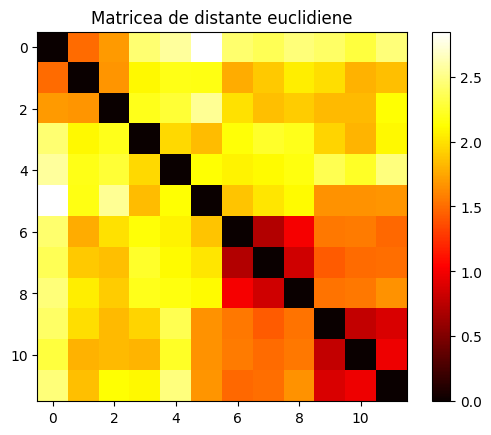

[[ 0  1  2]
 [ 0  1  2]
 [ 0  1  2]
 [ 3  5 10]
 [ 3  4  6]
 [ 5  9 10]
 [ 6  7  8]
 [ 6  7  8]
 [ 6  7  8]
 [ 9 10 11]
 [ 9 10 11]
 [ 9 10 11]]
Nr. fete gasite din 12 =  9
Acuratetea = 75.0
Rata de clasificare  0.75


In [6]:
# (optional, pentru testare hog)
mask=np.array([[2,1,1,1,1,1,2],
    [2,4,4,1,4,4,2],
    [1,1,1,0,1,1,1],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,2,1,1,0],
    [0,1,1,1,1,1,0]])

def calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari'):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),6*49])

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/7)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,0.05)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:3])
    print(calc_fete_primele3coloane)

    posibile = ['012','345','678','91011']

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(3):
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 12 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/12)*100)       
    print('Rata de clasificare ',nr_fete/12)

    return nr_fete

poze = os.listdir('Lab - 6 HOG/Mari')

descriptori_hog = calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari')

distante = calc_distante_descriptori(descriptori_hog)

# afisez matricea de distante
plt.imshow(distante, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Matricea de distante euclidiene')
plt.show()

nr_fete_corecte = calc_nr_fete_similare_dist(distante)

In [ ]:
# Ex 2

In [7]:
def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

In [16]:
def calc_descriptori_hog_poze(poze, path, threshold):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),6*2])

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/3)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):

                i_bloc = i // step
                j_bloc = j // step
                if ((i_bloc != 0 and j_bloc == 0) or (i_bloc != 0 and j_bloc == W//step - 1)) or (mask[i_bloc,j_bloc]%2 != 0):
                    continue
                
                print("am ales blocul, ",i_bloc,j_bloc, " pentru poza ",k)
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,threshold)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

In [17]:
poze = os.listdir('Mari_nr_2')
mask = np.array([[8,3,9],
                 [1,4,2],
                 [6,5,7]])
poze = os.listdir('Mari_nr_2')
path='Mari_nr_2'

descriptori_hog = calc_descriptori_hog_poze(poze, path, 0.05)

# afisez matricea de descriptori
print(descriptori_hog)


am ales blocul,  0 0  pentru poza  0
am ales blocul,  1 1  pentru poza  0
am ales blocul,  0 0  pentru poza  1
am ales blocul,  1 1  pentru poza  1
am ales blocul,  0 0  pentru poza  2
am ales blocul,  1 1  pentru poza  2
am ales blocul,  0 0  pentru poza  3
am ales blocul,  1 1  pentru poza  3
am ales blocul,  0 0  pentru poza  4
am ales blocul,  1 1  pentru poza  4
am ales blocul,  0 0  pentru poza  5
am ales blocul,  1 1  pentru poza  5
am ales blocul,  0 0  pentru poza  6
am ales blocul,  1 1  pentru poza  6
am ales blocul,  0 0  pentru poza  7
am ales blocul,  1 1  pentru poza  7
am ales blocul,  0 0  pentru poza  8
am ales blocul,  1 1  pentru poza  8
am ales blocul,  0 0  pentru poza  9
am ales blocul,  1 1  pentru poza  9
am ales blocul,  0 0  pentru poza  10
am ales blocul,  1 1  pentru poza  10
am ales blocul,  0 0  pentru poza  11
am ales blocul,  1 1  pentru poza  11
am ales blocul,  0 0  pentru poza  12
am ales blocul,  1 1  pentru poza  12
am ales blocul,  0 0  pentru poz

In [ ]:
# Ex 3

In [19]:
def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:4])
    print(calc_fete_primele3coloane)

    posibile = ['0123','4567','891011','12131415']

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(4):
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 16 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/16)*100)       
    print('Rata de clasificare ',nr_fete/16)

    return nr_fete

In [22]:
def best_prag(thresholds):
    nr_fete_max = 0
    
    for threshold in thresholds:

        poze = os.listdir('Mari_nr_2')
        path='Mari_nr_2'
        descriptori_hog = calc_descriptori_hog_poze(poze, path, threshold)
        distante = calc_distante_descriptori(descriptori_hog)

        nr_fete_corecte = calc_nr_fete_similare_dist(distante)
        if nr_fete_corecte >= nr_fete_max:
            nr_fete_max = nr_fete_corecte
            best_threshold = threshold
    
    return best_threshold, nr_fete_max

In [23]:
best_threshold, nr_fete_max = best_prag([0.1, 0.3, 0.6])
print("Cel mai bun prag este ", best_threshold)
print("Numarul maxim de fete corecte este ", nr_fete_max)

am ales blocul,  0 0  pentru poza  0
am ales blocul,  1 1  pentru poza  0
am ales blocul,  0 0  pentru poza  1
am ales blocul,  1 1  pentru poza  1
am ales blocul,  0 0  pentru poza  2
am ales blocul,  1 1  pentru poza  2
am ales blocul,  0 0  pentru poza  3
am ales blocul,  1 1  pentru poza  3
am ales blocul,  0 0  pentru poza  4
am ales blocul,  1 1  pentru poza  4
am ales blocul,  0 0  pentru poza  5
am ales blocul,  1 1  pentru poza  5
am ales blocul,  0 0  pentru poza  6
am ales blocul,  1 1  pentru poza  6
am ales blocul,  0 0  pentru poza  7
am ales blocul,  1 1  pentru poza  7
am ales blocul,  0 0  pentru poza  8
am ales blocul,  1 1  pentru poza  8
am ales blocul,  0 0  pentru poza  9
am ales blocul,  1 1  pentru poza  9
am ales blocul,  0 0  pentru poza  10
am ales blocul,  1 1  pentru poza  10
am ales blocul,  0 0  pentru poza  11
am ales blocul,  1 1  pentru poza  11
am ales blocul,  0 0  pentru poza  12
am ales blocul,  1 1  pentru poza  12
am ales blocul,  0 0  pentru poz

In [24]:
# pt 8 poze (2 cate 2 la fel)

#initializez matrica de distante    
distante=np.zeros([8,8])

#calculez dist euclidiana intre toti descritorii asociati imaginilor
#inclusiv intre aceeasi descriptori
for k in range(distante.shape[0]):
    for l in range(distante.shape[1]):
        distante[k,l]=eucdist(descriptori_hog[k],descriptori_hog[l])


nr_fete=0

# np.sort - ordoneaza crescator valorile
# np.argsort - ordoneaza indicii in ordinea crescatoare a valorilor efective coresp. fiecarui indice
#prin aceasta metoda, vom obtine in matrice, pe primele 2 coloane, indicii distantelor celor mai mici pt poza respectiva
calc_fete = np.argsort(distante)

#stim ca in folder avem cate 2 poze pt fiecare poza, ordonate: 2xP1, 2xP2, 2xP3, 2xP4
# => pt poza P1 vrem sa obtinem indicii 0,1 (coresp primelor 2 imagini din folder)
#sortam primele 2 coloane pt a obtine mereu indicii in ord 
calc_fete = np.sort(calc_fete[:,:2])
print(calc_fete)
posibile = ['01','23','45','67']

for i in range(calc_fete.shape[0]):
    string = ''
    for j in range(2):
        string+= str(calc_fete[i,j])
    if string in posibile:
        nr_fete += 1
        
        
print('Nr de fete este ', nr_fete)

[[0 1]
 [1 3]
 [0 2]
 [1 3]
 [4 7]
 [5 6]
 [5 6]
 [4 7]]
Nr de fete este  1


In [ ]:
# Ex 4 (intrebare)

# Ce este imaginea integrala? De ce avem nevoie de ea?
# Imaginea integrala reprezinta o matrice ce contine suma cumulativa pe linii, apoi pe coloane (utilizand rezultatul de la linii).
# Astfel, primul element al matricei II va fi egal cu primul element al imaginii initiale, iar ultimul va contine suma tuturor valorilor din imaginea initiala.
# Folosim II pentru a calcula suma intensitatilor luminoase (suma pixelilor) din anumite regiuni specifice din imagine, deoarece in coltul din dreapta jos vom avea intotdeauna suma tuturor intensitatilor dintr-o imagine.

# Ne ajuta sa calculam rapid anumite caracteristici din imagine fara sa facem aceleasi operatii iar si iar